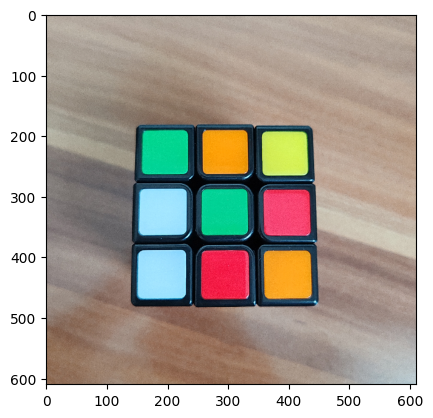

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Korak 1: Učitavanje slike
image = cv2.imread("Kocka4.jpg")

# Provjera veličine slike i umanjivanje prevelike slike
im_height, im_width, channels = image.shape

if im_height > 1000 and im_width > 1000:
    image = cv2.resize(image, (0, 0), fx = 0.2, fy = 0.2)

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(img)


In [37]:
# Funkcija za detekciju boje polja
def detect_color(tile):
    avg_color = tile.mean(axis=0).mean(axis=0)
    return avg_color


# Funkcija za provjeru preklapanja čelija kontura
def is_overlapping(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return not (x1 > x2 + w2 or x2 > x1 + w1 or y1 > y2 + h2 or y2 > y1 + h1)

# Funkcija za filtriranje čelija kontura koje se preklapaju 
def filter_overlapping_contours(contours):
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    filtered_contours = []
    
    for i, box1 in enumerate(bounding_boxes):
        keep = True
        for j, box2 in enumerate(bounding_boxes):
            if i != j and is_overlapping(box1, box2):
                if cv2.contourArea(contours[i]) < cv2.contourArea(contours[j]):
                    keep = False
                    break
        if keep:
            filtered_contours.append(contours[i])
    
    return filtered_contours


# Preset boje Rubikove kocke (RGB)
preset_colors_rgb = {
    'white': [255, 255, 255],
    'yellow': [175, 200, 10],
    'red': [255, 0, 0],
    'orange': [200, 100, 10],
    'green': [0, 255, 0],
    'blue': [0, 0, 255]
}

# Funkcija za usporedbu i postavljanje detektirane boje s preset bojama  
def closest_color(color, preset_colors):
    min_distance = float('inf')
    closest_color_name = None
    for name, preset_color in preset_colors.items():
        distance = np.linalg.norm(color - preset_color)
        if color[0] > 160 and color[1] < 80:
            closest_color_name = 'red'
            
        elif distance < min_distance:
            min_distance = distance
            closest_color_name = name
            
    return closest_color_name


(-0.5, 609.5, 609.5, -0.5)

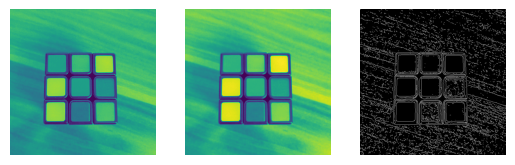

In [38]:
# Korak 2: Obrada slike 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.subplot(131); plt.imshow(gray)
plt.axis('off')
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.subplot(132); plt.imshow(blurred)
plt.axis('off')
edges = cv2.Canny(blurred, threshold1=20, threshold2=25)  #10, 20 ; 150, 350
plt.subplot(133); plt.imshow(edges, cmap='gray')
plt.axis('off')

(-0.5, 609.5, 609.5, -0.5)

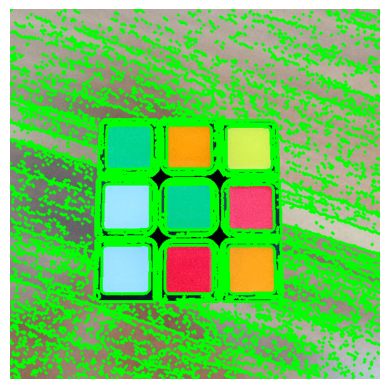

In [39]:
# Pronalaženje kontura
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iscrtavanje kontura na originalnoj slici
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 4)
plt.imshow(contour_img)
plt.axis('off')

(-0.5, 609.5, 609.5, -0.5)

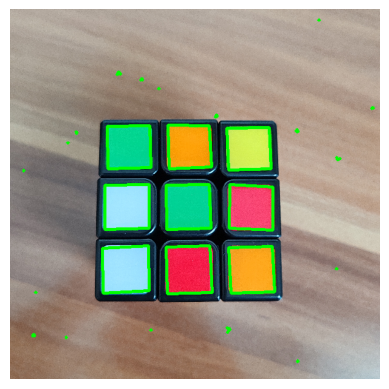

In [40]:
# Korak 4: Pronalaženje pojedinih polja stranice
# Filtriranje kontura za pronalaženje kvadrata (polja strance)
cube_contours = []

for contour in contours:
    epsilon = 0.15 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        cube_contours.append(approx)

if cube_contours is None:
    print("Rubik's cube not found")
    exit()

cube_contours = filter_overlapping_contours(cube_contours)

# Crtanje i prikaz filtriranih kontura
filtered_contour_img = img.copy()
cv2.drawContours(filtered_contour_img, cube_contours, -1, (0, 255, 0), 4)
plt.imshow(filtered_contour_img)
plt.axis('off')



(-0.5, 609.5, 609.5, -0.5)

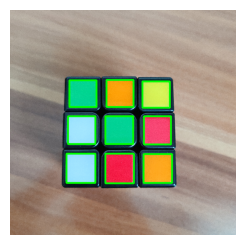

In [41]:
# Korak 5: Detekcija boja pojedinih polja
# Odvajanje polja i detekcija njihove boje
tiles = []
colors = []
positions = []
for contour in cube_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 50 and h > 50:
        tile = image[y:y+h, x:x+w]
        tiles.append(tile)
        color = detect_color(tile)
        colors.append(color)
        positions.append((x, y, w, h))
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 4)


# Sortiranje polja po vertikali-y (gore prema dolje)
positions_colors = sorted(zip(positions, colors), key=lambda b: b[0][1])

# Dijeljenje u redove (uzimajuči 3x3 raspored)
rows = [positions_colors[i:i+3] for i in range(0, len(positions_colors), 3)]

# Sortiranje svakog reda po horizontali-x (lijevo prema desno)
sorted_positions_colors = [sorted(row, key=lambda b: b[0][0]) for row in rows]

# Spajanje sortiranih redova u jednu listu
sorted_positions_colors = [color for row in sorted_positions_colors for _, color in row]

#plt.subplot(121); plt.imshow(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.subplot(122); plt.imshow(img)
plt.axis('off')

(-0.5, 2.5, 2.5, -0.5)

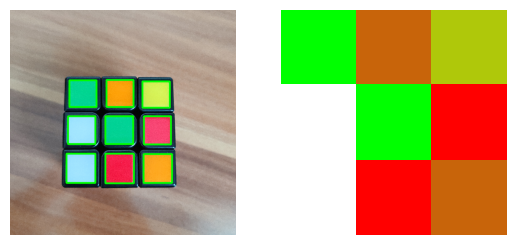

In [42]:
# Korak 6: Postavljanje detektiranih boja u 3x3 polje
# Pretvorba detektiranih BGR boja u RGB
colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2RGB)[0][0] for color in sorted_positions_colors]

# Postavljanje detektirane boje s najbližom preset bojom
closest_colors = [preset_colors_rgb[closest_color(color, preset_colors_rgb)] for color in colors_rgb]

# Provjera je li detektirano točno 9 boja za izradu 3x3 polja
if len(closest_colors) == 9:
    color_grid = np.array(closest_colors).reshape(3, 3, 3) / 255.0
else:
    print("Error: Detektirane bolje ne formiraju 3x3 polje")

# Prikaz originalne slike i slike izrađene od detektiranih boja 
plt.subplot(121); plt.imshow(img)
plt.axis("off")
plt.subplot(122); plt.imshow(color_grid)
plt.axis("off")
